# Фильтрация картинок при помощи pytorch torch.nn.Conv2d (фильтр Лапласа)

Прочитайте внимательно статью про то, что такое свёртка:

https://programforyou.ru/poleznoe/convolutional-network-from-scratch-part-zero-introduction

In [1]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms

Пусть задана цветная картинка с изображением бабочки:

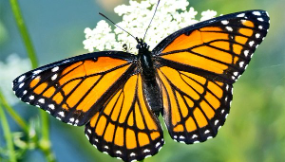

In [2]:
filename = 'image.png'
image = Image.open(filename)
image = image.convert('RGB')
image

Цель задания в том, чтобы реализовать функцию, которая бы по заданным входному изображению и матрицей размера 3x3, получала бы фильтрованное изображение, как на рисунке ниже:

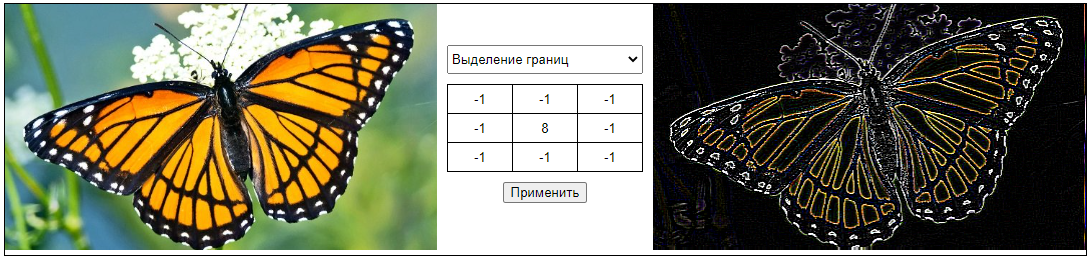

In [3]:
filename = 'laplace filter.png'
filter_example = Image.open(filename)
filter_example = filter_example.convert('RGB')
filter_example

Для реализации фильтра необходимо использовать свёртку, которая осуществляется модулем 'torch.nn.Conv2d'. В созданном объекте необходимо заменить имеющиеся веса на заданные веса фильтра, как в примере ниже:

(На входе 3х канальная картинка (ргб). Мы создаем конв блок и на выходе тоже хотим получить ргб картинку. => 3 in_channels, 3 out_channels. Когда создается фильтр, он на самом деле тоже трехканальный для трех ргб (то есть имеет грубину 3). Как я понимаю, каждый фильтр со своей глубиной 3 сразу применяется к трем каналам и "суммирует" их. И таких 3 фильтра. А мы в этой задаче каждый канал хотим обработать отдельно. К каждому каналу применить один фильтр, не трогая другие каналы. Можно использовать параметр groups.)

In [4]:
# Конволюционный слой
conv_model = nn.Conv2d(in_channels=3, # сколько входных фильтров
                       out_channels=3, # сколько фильтров хотим на выходе
                       groups=3, 
                       # если groups=in_channels, то к каждому входному слою применяется свой набор ядер 
                       # количеством out_channels / in_channels. То есть в данном случае к каждому входному 
                       # фильтру применится по одному ядру.
                       kernel_size=3, # размер ядра свертки
                       padding=1, # шаг, с которым передвигается ядро свертки
                       stride=1, # добавляем рамочку из нулей, чтобы выходная картинка не изменилась размером
                       bias=False) # смещение (которое +b)
print('Исходные случайные веса в слое:')
print(conv_model.weight)

Исходные случайные веса в слое:
Parameter containing:
tensor([[[[-0.2728,  0.1775,  0.0373],
          [-0.2875, -0.2710,  0.1199],
          [ 0.1562, -0.0923, -0.0074]]],


        [[[-0.2224,  0.0023,  0.1388],
          [-0.1099, -0.1540, -0.0726],
          [ 0.0412, -0.1116,  0.0440]]],


        [[[ 0.0450, -0.0082, -0.1237],
          [ 0.1583,  0.2490, -0.1263],
          [-0.0241,  0.0732, -0.1989]]]], requires_grad=True)


In [5]:
W = torch.tensor([[[[-1.,-2,-1],[0,0,0],[1,2,1]]],
                  [[[-1.,-2,-1],[0,0,0],[1,2,1]]],
                  [[[-1.,-2,-1],[0,0,0],[1,2,1]]]])

with torch.no_grad():
    conv_model.weight.copy_(W)

print('Новые веса в слое:')
print(conv_model.weight)

Новые веса в слое:
Parameter containing:
tensor([[[[-1., -2., -1.],
          [ 0.,  0.,  0.],
          [ 1.,  2.,  1.]]],


        [[[-1., -2., -1.],
          [ 0.,  0.,  0.],
          [ 1.,  2.,  1.]]],


        [[[-1., -2., -1.],
          [ 0.,  0.,  0.],
          [ 1.,  2.,  1.]]]], requires_grad=True)


In [6]:
import numpy as np
np.array(image).shape

(162, 285, 3)

Также необходимо научиться использовать стандартные трансформации из модуля 'torchvision.transforms' для того, чтобы преобразовывать картинку из формата, возвращаемого библиотекой 'PIL.Image' в 'torch.Tensor':
- transforms.ToTensor()
- transforms.ToPILImage()

In [7]:
t1 = transforms.ToTensor()  # тут все меняется: размер был (162, 285, 3), стал (3, 162, 285),
                            # значения в картинке становится от 0 до 1.
tensor_image = t1(image)
tensor_image.shape

torch.Size([3, 162, 285])

In [8]:
# добавляет доп размерность (нулевую) для батчей (1 значит 1 картинка)
tensor_image = tensor_image.unsqueeze(dim=0)
tensor_image.shape

torch.Size([1, 3, 162, 285])

In [9]:
result = conv_model(tensor_image)
result.shape

torch.Size([1, 3, 162, 285])

In [10]:
result = result.squeeze(dim=0)
# если значения в картинке больше 1, делаем их 1; если меньше 0, делаем их 0
result[result < 0] = 0
result[result > 1] = 1
result.shape

torch.Size([3, 162, 285])

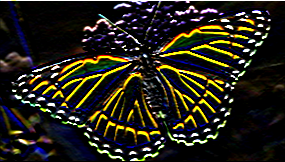

In [11]:
t2 = transforms.ToPILImage()
new_image = t2(result)
new_image

In [12]:
def fil(image, W):
    
    conv_model = nn.Conv2d(in_channels=3, # сколько входных фильтров
                       out_channels=3, # сколько фильтров хотим на выходе
                       groups=3, 
                       # если groups=in_channels, то к каждому входному слою применяется свой набор ядер 
                       # количеством out_channels / in_channels. То есть в данном случае к каждому входному 
                       # фильтру применится по одному ядру.
                       kernel_size=3, # размер ядра свертки
                       padding=1, # шаг, с которым передвигается ядро свертки
                       stride=1, # добавляем рамочку из нулей, чтобы выходная картинка не изменилась размером
                       bias=False) # смещение (которое +b)
    
    # Копируем вес
    with torch.no_grad():
        conv_model.weight.copy_(W)
        
    # преобразование из PIL.Image в torch.Tensor
    t1 = transforms.ToTensor()  
    tensor_image = t1(image) # тут все меняется: размер был (162, 285, 3), стал (3, 162, 285),
                             # значения в картинке становится от 0 до 1.
    
    tensor_image = tensor_image.unsqueeze(dim=0) # добавляет доп размерность (нулевую) для батчей (1 значит 1 картинка)
    result = conv_model(tensor_image)
    
    # обратное преобразование из torch.Tensor в PIL.Image
    result = result.squeeze(dim =0)
    # если значения в картинке больше 1, делаем их 1; если меньше 0, делаем их 0
    result[result < 0] = 0
    result[result > 1] = 1
    t2 = transforms.ToPILImage()
    new_image = t2(result)
        
    return new_image

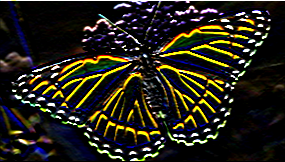

In [13]:
W1 = torch.tensor([[[[-1.,-2,-1],[0,0,0],[1,2,1]]], 
                  [[[-1.,-2,-1],[0,0,0],[1,2,1]]],
                  [[[-1.,-2,-1],[0,0,0],[1,2,1]]]])
i1 = fil(image, W1)
i1